# Trabajo Practico Final
# Integrantes:
#    -Ezequiel Arevalo

# https://vizhub.healthdata.org/gbd-results/
# https://datacommons.org/place/country/URY
https://datos.bancomundial.org/indicator/SI.POV.NAHC?locations=XJ
https://datos.bancomundial.org/pais/brasil?view=chart

https://statistics.cepal.org/portal/databank/index.html?lang=es&indicator_id=3333&area_id=930&members=216%2C221%2C222%2C224%2C225%2C226%2C229%2C230%2C235%2C239%2C233%2C240%2C241%2C242%2C244%2C264%2C258%2C259%2C43053%2C330%2C29170%2C29171%2C29172%2C29173%2C29174%2C29175%2C29176%2C29177%2C29178%2C29179%2C29180%2C29181%2C29182%2C29183%2C29184%2C29185%2C29186%2C29187%2C29188%2C29189%2C29190%2C29191%2C31709%2C31745

https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimates-of-rates-of-homicides-per-100-000-population

In [41]:
# Carga de archivos
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

PAISES ={
    "ARG":"Argentina", 
    "BRA":"Brazil",  
    "CHL":"Chile",
    "PER":"Peru",
    "URY":"Uruguay", 
}

POBREZA_FILE = "data/pobreza.csv"
MUERTES_FILE = "data/muertes.csv"
PBI_FILES = [
    "data/argentina/pbi.csv",
    "data/brasil/pbi.csv"
    "data/chile/pbi.csv",
    "data/peru/pbi.csv",
    "data/uruguay/pbi.csv"
]

In [42]:
data = { key: {} for key,value in PAISES.items() }

pobreza_df = pd.read_csv(POBREZA_FILE, sep=",") 
muertes_df = pd.read_csv(MUERTES_FILE, sep=",")
pbi_df = { 
    key: pd.read_csv(f"data/{value.lower()}/pbi.csv", sep=",")  for key,value in PAISES.items()
}
pobreza_json = pd.read_json("data/pobreza.json")


muertes_x_droga_df = muertes_df[ (muertes_df["cause_name"]=="Drug use disorders") & (muertes_df["measure_name"] == "Deaths") ]
muertes_cada_100k_hab = pd.read_csv("data/muertes_x_100k.csv", sep=",")


In [43]:
DIM_POBREZA,POBREZA, POBREZA_EXTREMA = "dim_1361",1362,1363 # ID de dimensiones de pobreza y pobreza extrema

anos_idx = {
     it["id"] : it["name"]  for it in [ dim["members"] for dim in pobreza_json["body"]["dimensions"] if dim["id"] == 29117 ][0]
}

for key, value in data.items():
    for id, ano in anos_idx.items():
        data[key][ano] = {
            "pobreza": None,
            "pbi": None,
            "homicidios": None,
            "sobredosis": None
        }

for it in pobreza_json["body"]["data"]:
    ano = anos_idx[ it["dim_29117"] ]
    pais = it["iso3"]
    pbi = pbi_df[pais]
    
    homicidios = muertes_cada_100k_hab[ (muertes_cada_100k_hab["SpatialDimValueCode"] == pais) & (muertes_cada_100k_hab["Period"] == int(ano)) ]["FactValueNumericHigh"].values
    sobredosis = muertes_x_droga_df[ (muertes_x_droga_df["location_name"] == PAISES[pais]) & (muertes_x_droga_df["year"] == int(ano)) & (muertes_x_droga_df["metric_name"] == "Number") ]["val"].values

    data[ pais ][ ano ]["pobreza"] = float(it["value"]) if it[DIM_POBREZA] == POBREZA else data[ pais ][ ano ]["pobreza"]
    data[ pais ][ ano ]["pbi"] = pbi[ pbi["label"] == int(ano) ]['GDP Per Capita'].values[0]
    data[ pais ][ ano ]["homicidios"] = homicidios[0] if len(homicidios) > 0 else None
    data[ pais ][ ano ]["sobredosis"] = sobredosis[0] if len(sobredosis) > 0 else None

dataframes = {}
for key, value in data.items():
    dataframes[key] = pd.DataFrame.from_dict(data[key], orient='index')

for df in dataframes.values():
    df.interpolate(inplace=True)

In [44]:
from sklearn.preprocessing import StandardScaler

keys = dataframes["ARG"].columns

std_scaler = StandardScaler()

df_stds = {}
for key,value in dataframes.items():
    df_stds[key] = pd.DataFrame(std_scaler.fit_transform(value), index=value.index, columns=value.columns)
    df_stds[key].reset_index(inplace=True)
    df_stds[key].rename(columns={"index":"ano"}, inplace=True)
    df_stds[key]["ano"]=df_stds[key]["ano"].apply(pd.to_numeric)


,ano,pobreza,pbi,homicidios,sobredosis
0,2000,0.877855,-0.453208,0.689125,-1.350349
1,2001,1.411003,-0.597909,2.024837,-1.138168
2,2002,2.854179,-1.932686,2.679931,-1.078545
3,2003,1.714346,-1.713495,1.531389,-1.225602
4,2004,1.080084,-1.444472,-0.195678,-1.242851
5,2005,0.602089,-1.203526,-0.672110,-1.125254
6,2006,0.004596,-0.969594,-0.876295,-0.921240
7,2007,-0.096518,-0.585805,-1.301681,-0.702491
8,2008,-0.390669,-0.071928,-1.063465,-0.606119
9,2009,-0.620474,-0.302593,-1.054957,-0.437637


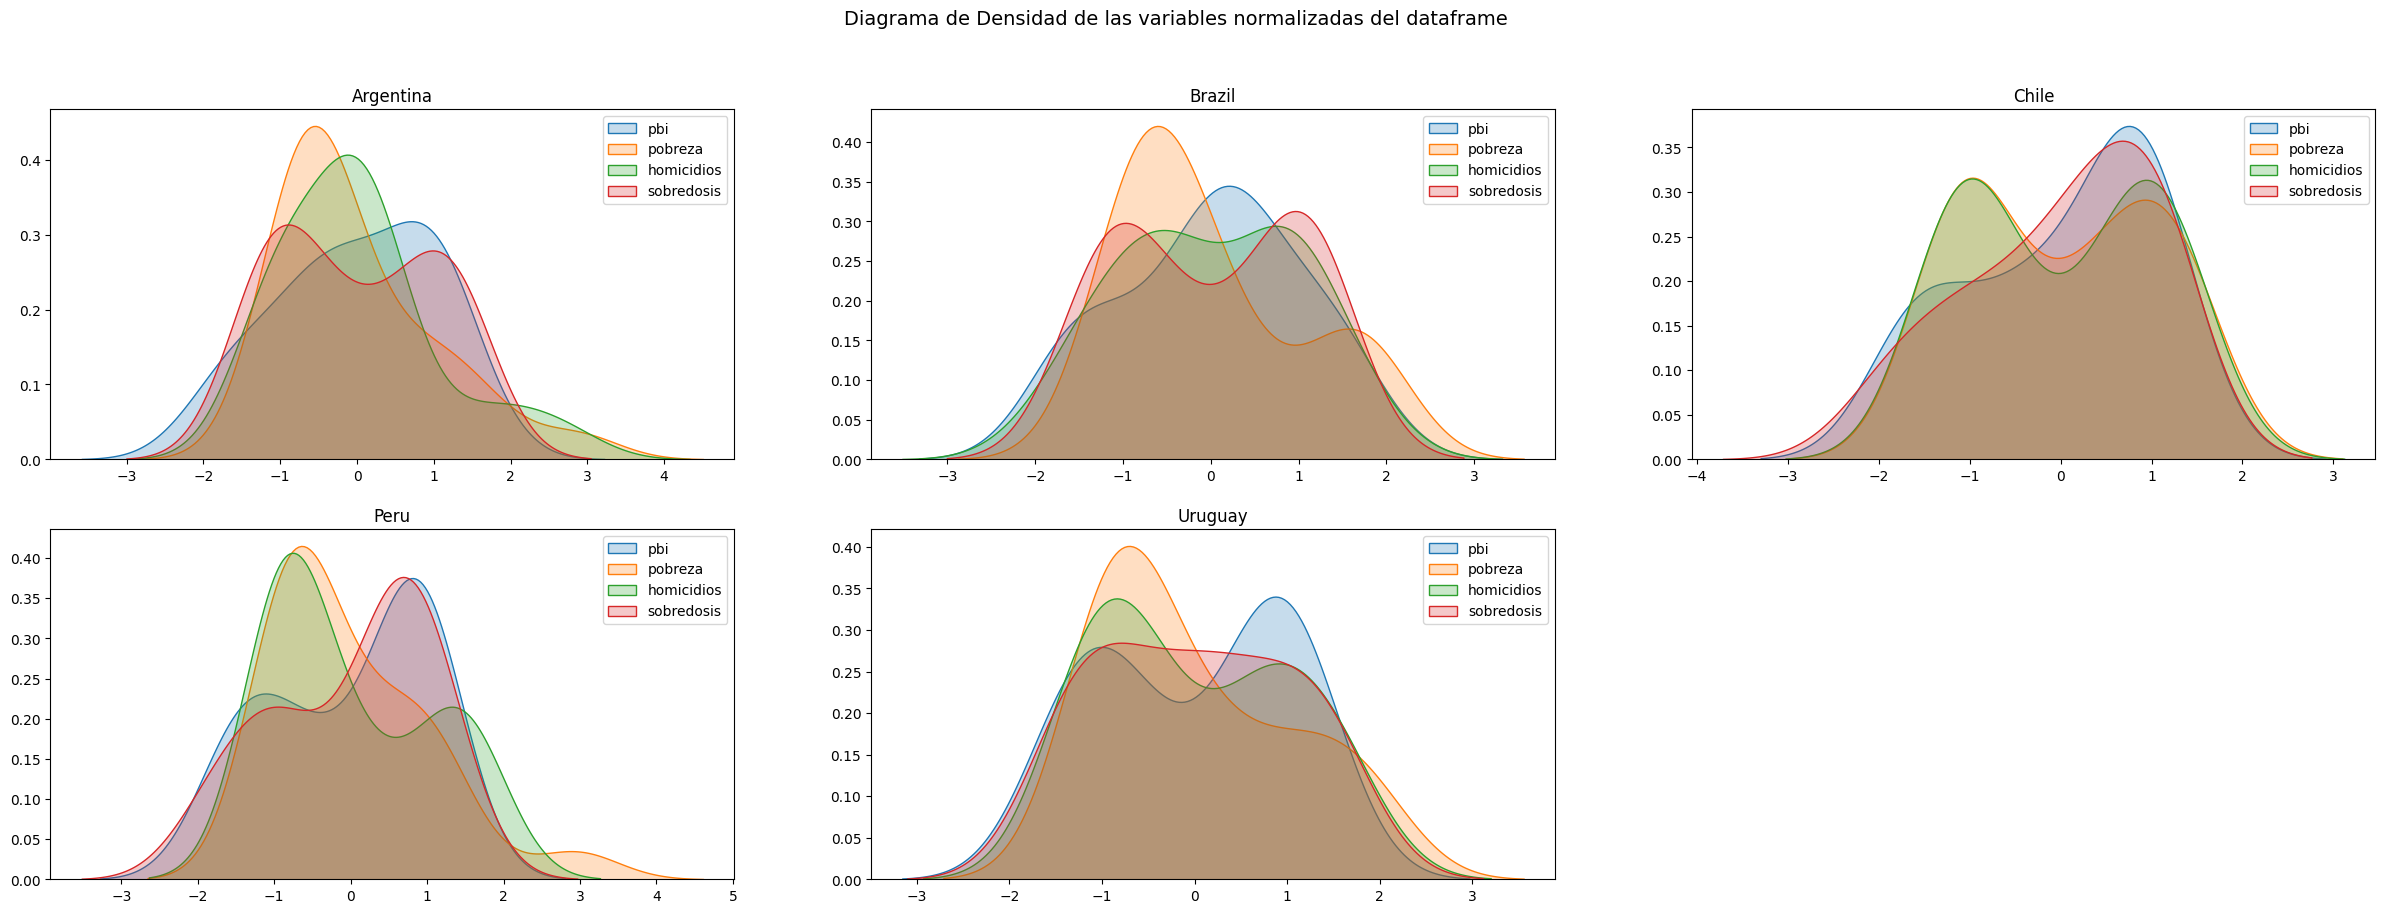

In [45]:
import seaborn as sns


x=2
y=3

fig, axs = plt.subplots(x,y,sharey=False,sharex=False,figsize=(30,10) )

k = 0
axes = [(i,j) for i in range(0,x) for j in range(0,y)]

for key,pais in df_stds.items():
    i,j = axes[k]
    sns.kdeplot(data=pais["pbi"], label="pbi", bw_adjust=1,fill=True, ax=axs[i,j])
    sns.kdeplot(data=pais["pobreza"], label="pobreza", bw_adjust=1,fill=True, ax=axs[i,j])
    sns.kdeplot(data=pais["homicidios"], label="homicidios", bw_adjust=1,fill=True, ax=axs[i,j])
    sns.kdeplot(data=pais["sobredosis"], label="sobredosis", bw_adjust=1,fill=True, ax=axs[i,j])

    axs[i][j].set_title(f"{PAISES[key]}")
    axs[i][j].set_ylabel('')
    axs[i][j].set_xlabel('')
    axs[i][j].legend()
    k+=1

fig.delaxes( axs[1][2] )
fig.suptitle("Diagrama de Densidad de las variables normalizadas del dataframe", fontsize=14)
plt.show()



ARG [[ 1.   -0.93  0.35 -0.64]
 [-0.93  1.   -0.17  0.7 ]
 [ 0.35 -0.17  1.    0.01]
 [-0.64  0.7   0.01  1.  ]]
BRA [[ 1.   -0.81  0.1  -0.75]
 [-0.81  1.   -0.32  0.57]
 [ 0.1  -0.32  1.    0.23]
 [-0.75  0.57  0.23  1.  ]]
CHL [[ 1.   -0.83  0.82 -0.98]
 [-0.83  1.   -0.75  0.8 ]
 [ 0.82 -0.75  1.   -0.85]
 [-0.98  0.8  -0.85  1.  ]]
PER [[ 1.   -0.9  -0.72 -0.55]
 [-0.9   1.    0.85  0.67]
 [-0.72  0.85  1.    0.5 ]
 [-0.55  0.67  0.5   1.  ]]
URY [[ 1.   -0.95 -0.86 -0.89]
 [-0.95  1.    0.82  0.93]
 [-0.86  0.82  1.    0.84]
 [-0.89  0.93  0.84  1.  ]]


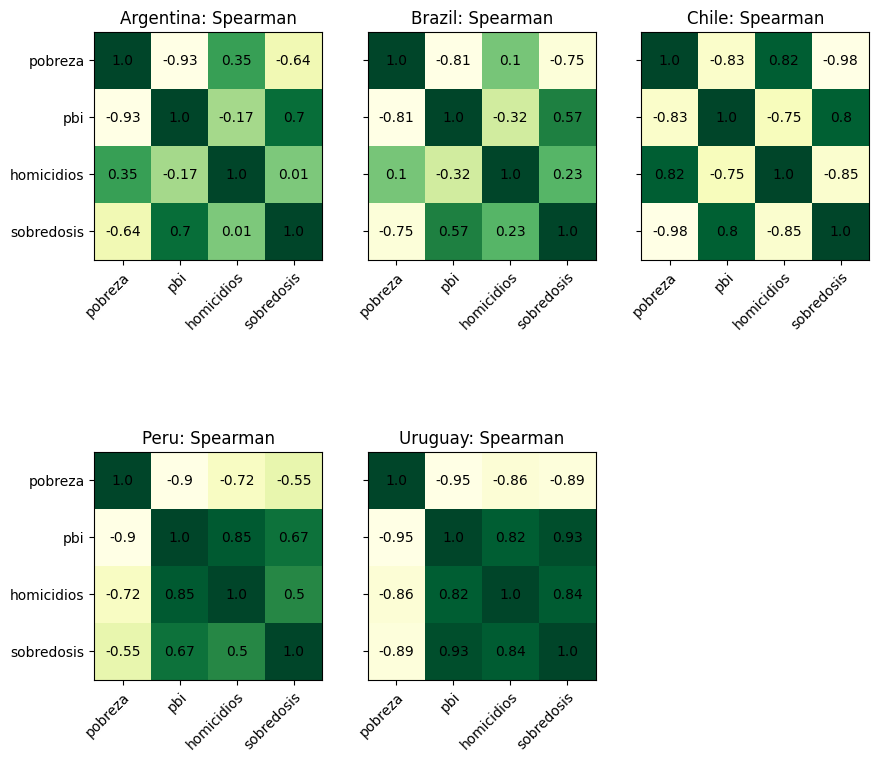

In [47]:
import numpy as np

corr_spearman= {k: v.drop(columns=["ano"]).corr(method = 'spearman').round(2).values for k,v in df_stds.items() }
keys = [ k for k in df_stds["ARG"].columns if k != "ano" ]

fig, axs = plt.subplots(x,y,sharey=True,sharex=False,figsize=(10,10) )

k=0
for key,data in corr_spearman.items():
        i,j=axes[k]
        ims = axs[i][j].imshow(data, cmap="YlGn")


        axs[i][j].set_xticks(range(len(keys)), labels=keys)
        axs[i][j].set_yticks(range(len(keys)), labels=keys)
        plt.setp(
                axs[i][j].get_xticklabels(), 
                rotation=45, ha="right",
                rotation_mode="anchor"
        )

        for m in range(len(keys)):
                for n in range(len(keys)):
                        axs[i][j].text(m, n, data[m, n],
                                ha="center", va="center", color="black")
                
        axs[i][j].set_title(f"{PAISES[key]}: Spearman")
        k+=1

plt.delaxes(axs[1][2])